## Packages
The usual suspects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, sigmoid, relu

%matplotlib widget
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from public_tests import *
from autils import *
from lab_utils_softmax import plt_softmax

np.set_printoptions(precision=2)

## Activation
The new ReLU (Rectified Linear Unit) activation function.
mRecall, it's basically max(0, linear)
It's not useful for binary, like sigmoid, but gives a continuous range of values.
It's useful when a negative value does not make sense.
It is also useful in allowing multiple units to contribute to the resulting function without interfering with each other.

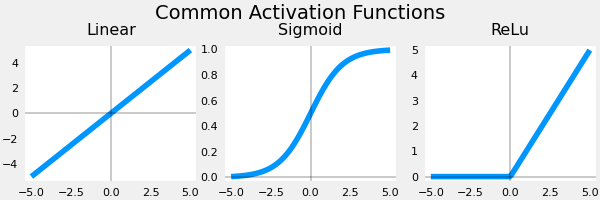

In [5]:
plt_act_trio()

## Softmax
A multiclass network with N outputs, where 1 is selected as the predicted answer based on probability.
In the output layer, a vector, z, is generated by a linear function which is fed into a softmax function, which converts z into a probability distribution - each output gets 
put into 

[0, 1] such that the sum of all outputs is 1

$$
\Large
a_j = \frac {e^{z_j}} {\sum^{N - 1}_{k = 0} e^{z_k}}
$$

In [7]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

And below, vary the z-values. Note the significant change in probability with only slight differences in values of z (also see previous lab):

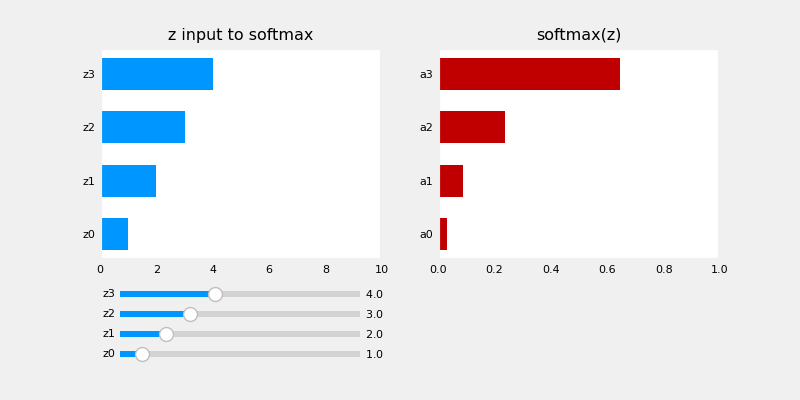

In [8]:
plt.close("all")
plt_softmax(softmax)

With an implementation of softmax, we can now update the previous 2-digit recognition system with a full 10-digit one.
The dataset has 5000 images, 20x20 grayscale, unrolled into a 400-dim vector, allowing a simplified X which remains 2D, at 5000x400
y has 10 labels, 0-9, corresponding to the digits, easily enough.

As usual, visualize data for fun and profit.

In [11]:
X, y = load_data()

print(f"Dimensions: {X.shape, y.shape}")
print(f"An element of X: {X[0]}")
print(f"An element of y: {y[0]}")

Dimensions: ((5000, 400), (5000, 1))
An element of X: [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2

Randomly select and draw 64 images from the dataset:

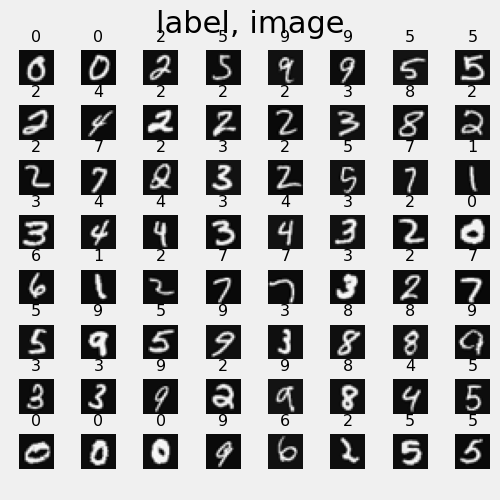

In [15]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(5, 5))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])

widgvis(fig)
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    
    ax.imshow(X_random_reshaped, cmap="gray")
    ax.set_title(y[random_index, 0])
    ax.set_axis_off()
    fig.suptitle("label, image", fontsize="22")
    

## Model
2 Dense layers, ReLU activation. 25 and 15 units.
Output layer, lienar activation. 10 units.
Softmax - separately applied.
Input layer is 400 units, as discussed.


In [16]:
tf.random.set_seed(1234)

In [19]:
model = Sequential(
    [
        tf.keras.Input(shape=(400,)),
        Dense(units=25, activation='relu'),
        Dense(units=15, activation='relu'),
        Dense(units=10, activation='linear')
    ], name='my_model'
)

model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 25)                10025     
_________________________________________________________________
dense_4 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                160       
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________


Examine and verify -

In [24]:
l1, l2, l3 = model.layers
w_b = [l.get_weights() for l in [l1, l2, l3]]
print(f"Shapes: {[(w.shape, b.shape) for [w, b] in w_b]}")

Shapes: [((400, 25), (25,)), ((25, 15), (15,)), ((15, 10), (10,))]


Use the loss function, and specify that we'll be using softmax with it with the logits param. Also, use Adam:

In [25]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

history = model.fit(
    X, y, epochs=40
)

2022-07-19 02:03:27.357900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-19 02:03:27.381036: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3693200000 Hz


Epoch 1/40
157/157 [==============================] - 0s 1ms/step - loss: 1.9005
Epoch 2/40
157/157 [==============================] - 0s 1ms/step - loss: 0.6544
Epoch 3/40
157/157 [==============================] - 0s 1ms/step - loss: 0.4526
Epoch 4/40
157/157 [==============================] - 0s 1ms/step - loss: 0.3613
Epoch 5/40
157/157 [==============================] - 0s 2ms/step - loss: 0.3030
Epoch 6/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2899
Epoch 7/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2604
Epoch 8/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2525
Epoch 9/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2258
Epoch 10/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1931
Epoch 11/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2027
Epoch 12/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1964
Epoch 13/40
157/157 [====

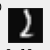

Prediction a 2:
[[ -7.39   6.35   9.03   4.76 -13.39 -12.1   -3.19   2.8   -4.13  -6.38]]
Largest index: 2
Probability distribution: 
[[6.86e-08 6.32e-02 9.22e-01 1.29e-02 1.70e-10 6.16e-10 4.53e-06 1.82e-03
  1.77e-06 1.87e-07]]
0.9999999403953552


In [29]:
# A 2
i2 = X[1015]
display_digit(i2)

prediction = model.predict(i2.reshape(1, 400))
pred_softmax = tf.nn.softmax(prediction)

print(f"Prediction a 2:\n{prediction}")
print(f"Largest index: {np.argmax(prediction)}")
print(f"Probability distribution: \n{pred_softmax}\n{np.sum(pred_softmax)}")

And then, with a random selection, compare predictions to actual labels:

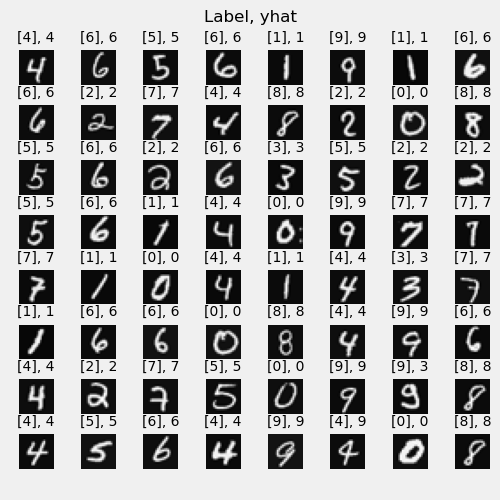

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(5, 5))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])
widgvis(fig)
for i, ax in enumerate(axes.flat):
    r = np.random.randint(m)
    X_r = X[r].reshape((20, 20)).T
    ax.imshow(X_r, cmap='gray')
    
    prediction = model.predict(X[r].reshape(1, 400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    ax.set_title(f"{y[r]}, {yhat}", fontsize=10)
    ax.set_axis_off()
    
fig.suptitle("Label, yhat", fontsize=12)
plt.show()

Which parts went wrong?
More epochs or more data can fix these, maybe:

38 errors out of 5000 images.


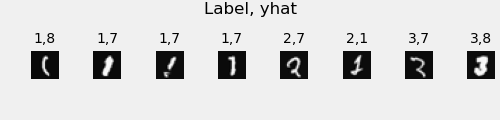

In [31]:
print(f"{display_errors(model, X, y)} errors out of {len(X)} images.")